In [19]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

# custom packages
import src.commons.dataset as ds
import src.commons.constants as cons

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# Vision Transformer approach

The ViT is an architecture that leverages transformers to image-based tasks. 

The main idea is to convert input image into a sequence of patches. We embed this sequence with a linear layer, plus positional encoding. Then, we apply a multi-head transformer layer. The output features are then used to solve the given task, e.g. classification.

The idea is to frame our anomaly detection as a weakly supervised problem, where weak binary labels $y$ are given. $y = 0$ means the image is normal, $y=1$ means the image is anomalous. This is called *weak* supervision because no information about *where* the anomaly is (i.e. ground truth mask) is supplied.

Then, we train a ViT in the task of predicting $\hat{y}$. By extracting information from the attention layers inside the transformer, we should be able to obtain anomaly masks. This should be the case because the attention should learn to prioritize anomalous regions in order to perform the classification task.

## DataLoader and data pre-processing

In [2]:
# Load dataset
cat = "capsule"
data = ds.MVTECTestDataset(os.path.join(ds.current_dir(),'../', cons.DATA_PATH), cat)

# Split data into train/test/val
lengths = torch.floor(torch.tensor([0.8, 0.1, 0.1])*len(data))
diff = torch.abs(lengths.sum() - len(data))
if diff > 0:
    lengths[0] += diff

train_data, test_data, val_data = torch.utils.data.random_split(data, lengths.to(int).tolist())

In [3]:
PATCH_SIZE = 50

def collate_fn(x):
    ''' 
    x: list - batch_size
    
    Converts list of input tensors (C, W, H) to batch.
    Normalizes each image from 0-255 to 0-1.
    For each image, convert it into sequence of W/P vectors of dimension C*P**2,
    where P is a fixed patch size.

    output: Tensor - (batch_size, W/P, C*P**2)
    '''   
    # Extract input images and labels
    imgs = [data["test"] for data in x]

    targets = [1 if torch.any(data["ground_truth"] > 0) else 0
               for data in x]

    C, W, H = imgs[0].shape

    # Convert images to 0-1
    imgs = [img / 255.0 for img in imgs]

    # Extract patches 
    patch_size = PATCH_SIZE
    temp = []
    for id, img in enumerate(imgs):
        # Cut up image into flatenned sequence of patches
        patches = [img[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size].flatten()
                   for i in range(W//patch_size) for j in range(H//patch_size)]
        patches = torch.stack(patches)
        temp.append(patches)
    
    # Convert to tensor
    data, targets = torch.stack(temp), torch.tensor(targets)
    return data, targets

In [4]:
# Define DataLoaders for batching input
BATCH_SIZE = 4

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Check if loaders are working properly
def test_dataloader(data_loader):
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:   
        data, targets = batch
    return 

test_dataloader(train_dataloader)

100%|██████████| 27/27 [00:04<00:00,  5.85it/s]


## Defining the model architecture

In [113]:
# Define model
class VisionTransformer(nn.Module):
    def __init__(self, seq_len, input_features, num_encoder_layers, d_model, nhead):
        '''
        Inputs:
         seq_len: int,  input sequence lenght i.e number of patches
         input_features: int,   (patch_size)**2 * channels
         num_encoder_layers: int,   number of consecutive Transformer layers
         d_model: int,   hidden dimension used throughout Transformers
         nhead: int, number of heads of each Transformer 
        '''
        super().__init__()
        
        self.linear = nn.Linear(in_features=input_features, out_features=d_model)
        self.pe_encoder = PositionalEncoding(d_model)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, nhead),
                                                 num_layers=num_encoder_layers)
        self.output = nn.Linear(in_features=d_model*seq_len, out_features=1)
        

    def forward(self, x):
        logging.debug(f"DTypes: raw input {type(x)}")

        x = self.linear(x)

        logging.debug(f"DTypes: linear output {type(x)}")
        logging.debug(f"PE Encoder: input (after Linear) {x.shape}, permuted {torch.swapdims(x, 0, 1).shape}")

        u = self.pe_encoder(torch.swapdims(x, 0, 1))
        logging.debug(f"PE Encoder: output {u.shape}, permuted: {torch.swapdims(u, 0, 1).shape}")
        x += torch.swapdims(u, 0, 1)
        x = self.encoder(x)
        logging.debug(f"Pre logits: {x.shape}")
        logits = self.output(torch.flatten(x, start_dim=1, end_dim=2))
        logging.debug(f"Logits: {logits.shape}")
        return logits.squeeze()

class PositionalEncoding(nn.Module):
    ''' 
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    '''
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        logging.debug(f"DTypes: PE before droput output {type(x)}")
        return self.dropout(x)

## Training and inference routines

In [114]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get('loss_fn', torch.nn.functional.binary_cross_entropy_with_logits)
    device = kwargs.get('device', torch.device('cpu'))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss = 0.
    for i, batch in pbar:
        data, targets = batch
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad(): # no need to compute gradients
            logits = model(data)
        loss = loss_fn(logits.float(), targets.float())
        avg_loss += loss.item()
        pbar.set_description(f'loss = {loss:.3f}')
    avg_loss /= len(data_loader)
    return avg_loss

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get('num_epochs', 100)
    loss_fn = kwargs.get('loss_fn', torch.nn.functional.binary_cross_entropy_with_logits)
    device = kwargs.get('device', torch.device('cpu'))
    
    train_loss_hist, val_loss_hist = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        print('Training phase...')
        model.train() # set model to training mode
        train_loss = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            data, targets = batch
            data, targets = data.to(device), targets.to(device)
            model.zero_grad() # initialize gradients to zero
            logits = model(data) # forward pass
            logging.debug(f"Before loss computation (training), logits: {logits.shape} targets: {targets.shape}")
            logging.debug(f"DTypes: logits {type(logits)}, targets {type(targets)}")
            loss = loss_fn(logits.float(), targets.float()) # loss computation
            loss.backward() # computing gradients (backward pass)
            optimizer.step() # updating the parameters of the model
            
            train_loss += loss.item()
            pbar.set_description(f'loss = {loss:.3f}')
        train_loss /= len(train_loader)
        print(f'train loss = {train_loss:.3f}')
        train_loss_hist.append(train_loss)
        
        print('Validation phase...')
        val_loss = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f'validation loss = {val_loss:.3f}')
        val_loss_hist.append(val_loss)
        
    return train_loss_hist, val_loss_hist


## Model training

In [115]:
# Define DataLoaders for batching input
BATCH_SIZE = 10

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Define hyperparameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50

SEQUENCE_LENGTH = 400
INPUT_FEATURES = 7500
ENCODER_LAYERS = 1
ENCODER_DIM = 128
ENCODER_HEADS = 8

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

model = VisionTransformer(SEQUENCE_LENGTH, INPUT_FEATURES, ENCODER_LAYERS, ENCODER_DIM, ENCODER_HEADS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

DEVICE: cuda


In [116]:
train_loss, val_loss = fit(model, train_dataloader, val_dataloader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)

Epoch 1/50
Training phase...


loss = 1.049: 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


train loss = 0.804
Validation phase...


loss = 2.243: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


validation loss = 1.793
Epoch 2/50
Training phase...


loss = 0.142: 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]


train loss = 0.741
Validation phase...


loss = 1.063: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


validation loss = 0.859
Epoch 3/50
Training phase...


loss = 0.456: 100%|██████████| 11/11 [00:05<00:00,  1.87it/s]


train loss = 0.595
Validation phase...


loss = 0.640: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


validation loss = 0.587
Epoch 4/50
Training phase...


loss = 0.311: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


train loss = 0.512
Validation phase...


loss = 0.647: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


validation loss = 0.581
Epoch 5/50
Training phase...


loss = 0.634: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


train loss = 0.548
Validation phase...


loss = 1.241: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


validation loss = 0.998
Epoch 6/50
Training phase...


loss = 0.453: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


train loss = 0.479
Validation phase...


loss = 0.812: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


validation loss = 0.673
Epoch 7/50
Training phase...


loss = 0.178: 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


train loss = 0.478
Validation phase...


loss = 0.884: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


validation loss = 0.725
Epoch 8/50
Training phase...


loss = 0.684: 100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


train loss = 0.491
Validation phase...


loss = 0.630: 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


validation loss = 0.587
Epoch 9/50
Training phase...


loss = 0.424: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


train loss = 0.482
Validation phase...


loss = 0.700: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


validation loss = 0.600
Epoch 10/50
Training phase...


loss = 0.323: 100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


train loss = 0.460
Validation phase...


loss = 0.682: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


validation loss = 0.589
Epoch 11/50
Training phase...


loss = 0.482: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


train loss = 0.447
Validation phase...


loss = 0.797: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


validation loss = 0.663
Epoch 12/50
Training phase...


loss = 0.485: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


train loss = 0.459
Validation phase...


loss = 0.969: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


validation loss = 0.790
Epoch 13/50
Training phase...


loss = 0.197: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


train loss = 0.472
Validation phase...


loss = 0.725: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


validation loss = 0.614
Epoch 14/50
Training phase...


loss = 0.950: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


train loss = 0.476
Validation phase...


loss = 0.629: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


validation loss = 0.564
Epoch 15/50
Training phase...


loss = 0.479: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


train loss = 0.467
Validation phase...


loss = 0.862: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


validation loss = 0.710
Epoch 16/50
Training phase...


loss = 0.442: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


train loss = 0.456
Validation phase...


loss = 0.704: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


validation loss = 0.600
Epoch 17/50
Training phase...


loss = 0.724: 100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


train loss = 0.453
Validation phase...


loss = 0.652: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


validation loss = 0.569
Epoch 18/50
Training phase...


loss = 0.110: 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


train loss = 0.417
Validation phase...


loss = 0.933: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


validation loss = 0.764
Epoch 19/50
Training phase...


loss = 0.670: 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


train loss = 0.534
Validation phase...


loss = 0.678: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


validation loss = 0.582
Epoch 20/50
Training phase...


loss = 0.228: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


train loss = 0.433
Validation phase...


loss = 0.650: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


validation loss = 0.566
Epoch 21/50
Training phase...


loss = 0.277: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


train loss = 0.433
Validation phase...


loss = 0.647: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


validation loss = 0.563
Epoch 22/50
Training phase...


loss = 0.723: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


train loss = 0.461
Validation phase...


loss = 0.776: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


validation loss = 0.648
Epoch 23/50
Training phase...


loss = 0.259: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


train loss = 0.424
Validation phase...


loss = 0.629: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


validation loss = 0.550
Epoch 24/50
Training phase...


loss = 0.045: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


train loss = 0.406
Validation phase...


loss = 1.216: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


validation loss = 0.988
Epoch 25/50
Training phase...


loss = 0.348: 100%|██████████| 11/11 [00:04<00:00,  2.20it/s]


train loss = 0.533
Validation phase...


loss = 0.604: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


validation loss = 0.535
Epoch 26/50
Training phase...


loss = 0.408: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


train loss = 0.462
Validation phase...


loss = 0.566: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


validation loss = 0.525
Epoch 27/50
Training phase...


loss = 0.055: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


train loss = 0.449
Validation phase...


loss = 0.905: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


validation loss = 0.748
Epoch 28/50
Training phase...


loss = 0.488: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


train loss = 0.441
Validation phase...


loss = 0.767: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


validation loss = 0.644
Epoch 29/50
Training phase...


loss = 0.822: 100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


train loss = 0.445
Validation phase...


loss = 0.542: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


validation loss = 0.499
Epoch 30/50
Training phase...


loss = 0.429: 100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


train loss = 0.445
Validation phase...


loss = 0.516: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


validation loss = 0.497
Epoch 31/50
Training phase...


loss = 0.181: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


train loss = 0.435
Validation phase...


loss = 0.605: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


validation loss = 0.531
Epoch 32/50
Training phase...


loss = 0.743: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


train loss = 0.430
Validation phase...


loss = 0.685: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


validation loss = 0.591
Epoch 33/50
Training phase...


loss = 0.578: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


train loss = 0.395
Validation phase...


loss = 0.458: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


validation loss = 0.462
Epoch 34/50
Training phase...


loss = 0.224: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]


train loss = 0.407
Validation phase...


loss = 0.461: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


validation loss = 0.436
Epoch 35/50
Training phase...


loss = 0.329: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


train loss = 0.437
Validation phase...


loss = 0.432: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


validation loss = 0.453
Epoch 36/50
Training phase...


loss = 0.328: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


train loss = 0.399
Validation phase...


loss = 0.724: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


validation loss = 0.631
Epoch 37/50
Training phase...


loss = 0.461: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


train loss = 0.410
Validation phase...


loss = 0.464: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


validation loss = 0.439
Epoch 38/50
Training phase...


loss = 0.329: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


train loss = 0.387
Validation phase...


loss = 0.351: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


validation loss = 0.380
Epoch 39/50
Training phase...


loss = 0.110: 100%|██████████| 11/11 [00:05<00:00,  1.95it/s]


train loss = 0.382
Validation phase...


loss = 0.362: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


validation loss = 0.367
Epoch 40/50
Training phase...


loss = 0.068: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


train loss = 0.374
Validation phase...


loss = 0.736: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


validation loss = 0.675
Epoch 41/50
Training phase...


loss = 0.423: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


train loss = 0.452
Validation phase...


loss = 0.279: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


validation loss = 0.332
Epoch 42/50
Training phase...


loss = 1.497: 100%|██████████| 11/11 [00:04<00:00,  2.26it/s]


train loss = 0.394
Validation phase...


loss = 0.442: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


validation loss = 0.455
Epoch 43/50
Training phase...


loss = 0.732: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


train loss = 0.404
Validation phase...


loss = 0.436: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


validation loss = 0.456
Epoch 44/50
Training phase...


loss = 0.228: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


train loss = 0.333
Validation phase...


loss = 0.246: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


validation loss = 0.303
Epoch 45/50
Training phase...


loss = 1.141: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]


train loss = 0.412
Validation phase...


loss = 0.224: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


validation loss = 0.289
Epoch 46/50
Training phase...


loss = 0.754: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


train loss = 0.382
Validation phase...


loss = 0.218: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


validation loss = 0.288
Epoch 47/50
Training phase...


loss = 0.797: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


train loss = 0.397
Validation phase...


loss = 0.372: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


validation loss = 0.430
Epoch 48/50
Training phase...


loss = 0.441: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


train loss = 0.341
Validation phase...


loss = 0.171: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


validation loss = 0.251
Epoch 49/50
Training phase...


loss = 0.191: 100%|██████████| 11/11 [00:05<00:00,  2.01it/s]


train loss = 0.313
Validation phase...


loss = 0.172: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


validation loss = 0.266
Epoch 50/50
Training phase...


loss = 0.064: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


train loss = 0.389
Validation phase...


loss = 0.186: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

validation loss = 0.286


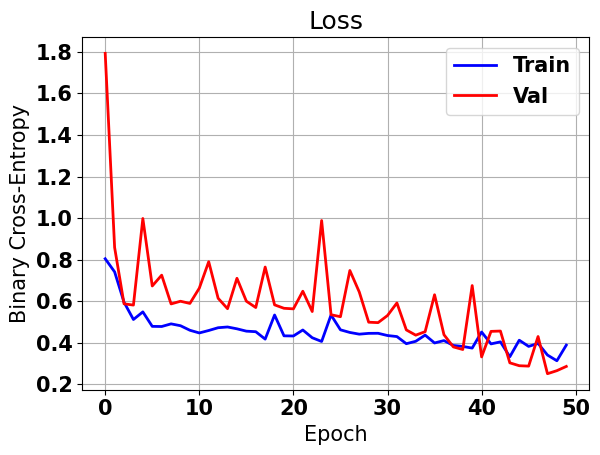

In [122]:
with plt.rc_context(rc={'font.size': 15, 'font.weight': 'bold'}):
    plt.title("Loss")
    plt.plot(train_loss, lw=2.0, c="b", label="Train")
    plt.plot(val_loss, lw=2.0, c="r", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.legend()
    plt.grid()
    plt.tight_layout()

## Visualize attention (WoP)

In order to visualize attention, we will follow [this notebook](https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map/notebook) and the article *"Quantifying Attention Flow in Transformers - Samira Abnar, Willem Zuidema"*

The basic idea is to retrieve attention values from transformer. Consider a single multi-head attention layer:

1. Average attention accross heads
2. Multiply attention matrices of consecutive blocks in order to accumulate their effect

In [163]:
# Only works for ENCODER_LAYERS = 1

model.eval()

def extract_attention_maps(model, data):
    with torch.no_grad():
        # Pre-process data with embedding layers
        x = model.linear(data)
        u = model.pe_encoder(torch.swapdims(x, 0, 1))
        x += torch.swapdims(u, 0, 1)
        # Apply self-attention
        transformer_layers = model.encoder.layers[0]
        attention, attention_weights = transformer_layers.self_attn(x, x, x, need_weights=True, average_attn_weights=True)
    return attention, attention_weights


attn_results, attn_weights_results = [] ,[]
pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
for i, batch in pbar:   
    data, targets = batch
    data, targets = data.to(DEVICE), targets.to(DEVICE)
    attn, attn_weights = extract_attention_maps(model, data)
    attn_results.append(attn.cpu().detach().numpy())
    attn_weights_results.append(attn_weights.cpu().detach().numpy())

100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


In [164]:
attn_results[0].shape, attn_weights_results[0].shape

((10, 400, 128), (400, 10, 10))

In [214]:
example_batch = attn_results[0]
example = example_batch[0]
# Normalize to 0-1
example = example.mean(-1)
example = (example - example.min(0))/(example.max(0) - example.min(0))

idx = 0
mask = np.zeros((1000, 1000))
for i in range(20):
    for j in range(20):
        idx = i + j
        patch_flat = example[idx]
        patch = patch_flat.mean() * np.ones((PATCH_SIZE, PATCH_SIZE))
        mask[(i*PATCH_SIZE):((i+1)*PATCH_SIZE), (j*PATCH_SIZE):((j+1)*PATCH_SIZE)] = patch
        

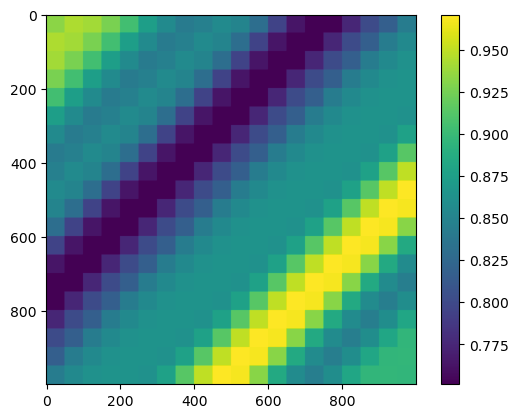

In [215]:
plt.imshow(mask)
plt.colorbar()